In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
names1=['Identificador','Numero_agentes','Tipo_red','Agente','Ronda','Estado','Puntaje','Politica','Parametro-0','Parametro-1','Politica_lag','Consistencia']
data = pd.read_csv('simulacionesKregular4.csv',names=names1,header=None)

In [30]:
print(data.shape)
data.head()

(1133000, 12)


,Identificador,Numero_agentes,Tipo_red,Agente,Ronda,Estado,Puntaje,Politica,Parametro-0,Parametro-1,Politica_lag,Consistencia
0,1200,5,Kregular,0,0,1,1,1,5,4,NaN,NaN
1,1200,5,Kregular,0,10,0,0,1,5,4,1.0,1.0
2,1200,5,Kregular,0,20,0,0,1,5,4,1.0,1.0
3,1200,5,Kregular,0,30,0,0,1,5,4,1.0,1.0
4,1200,5,Kregular,0,40,0,0,1,5,4,1.0,1.0


In [31]:
data_full = data.query('Tipo_red=="Kregular"').copy()

In [32]:
data_full.Numero_agentes.unique()

array([   5,    6,   10,   11,  101, 1000])

In [33]:
experimentos = data_full.groupby('Numero_agentes')['Identificador'].unique()
experimentos = experimentos.apply(len)
experimentos

Numero_agentes
5       100
6       100
10      100
11      100
101     100
1000    100
Name: Identificador, dtype: int64

Medida de asistencia óptima al bar El Farol:

Es un número entre 0 y 1, donde 1 significa que en todas las rondas, la asistencia al bar fue de 0.5; 0 significa que o bien la asistencia en todas las rondas fue 0 o 1.

$$ 1 - 2*\sqrt{\frac{\sum_{r}(Asistencia_{r} - 0.5)^2}{R}}$$

In [34]:
aux = data_full.groupby(['Numero_agentes', 'Identificador', 'Ronda'])['Estado']\
    .sum().reset_index()
aux.columns = ['Numero_agentes',
               'Identificador',
               'Ronda', 
               'Asistencia_total']

# Proporción de asistencia
aux['Asistencia'] = aux['Asistencia_total']/aux['Numero_agentes']
# Distancia al cuadrado entre proporción de asistencia y 0.5
aux['diferencia_con_umbral'] = (aux['Asistencia'] - 0.5)*(aux['Asistencia'] - 0.5)
aux.head()

,Numero_agentes,Identificador,Ronda,Asistencia_total,Asistencia,diferencia_con_umbral
0,5,1200,0,1,0.2,0.09
1,5,1200,10,3,0.6,0.01
2,5,1200,20,3,0.6,0.01
3,5,1200,30,3,0.6,0.01
4,5,1200,40,3,0.6,0.01


In [35]:
num_rondas = aux.Ronda.max() + 1
num_rondas

91

In [36]:
df = aux.groupby(['Numero_agentes', 'Identificador'])['diferencia_con_umbral'].sum().reset_index()
df['Asistencia_optima'] = df['diferencia_con_umbral']/num_rondas
df['Asistencia_optima'] = 1 - 2 * np.sqrt(df['Asistencia_optima'])
df.head()

,Numero_agentes,Identificador,diferencia_con_umbral,Asistencia_optima
0,5,1200,0.18,0.911050
1,5,1201,0.82,0.810148
2,5,1202,0.18,0.911050
3,5,1203,2.26,0.684816
4,5,1204,2.34,0.679287


In [37]:
df['Asistencia_optima'].describe()

count    600.000000
mean       0.839610
std        0.123222
min        0.668503
25%        0.685370
50%        0.874206
75%        0.959568
max        1.000000
Name: Asistencia_optima, dtype: float64

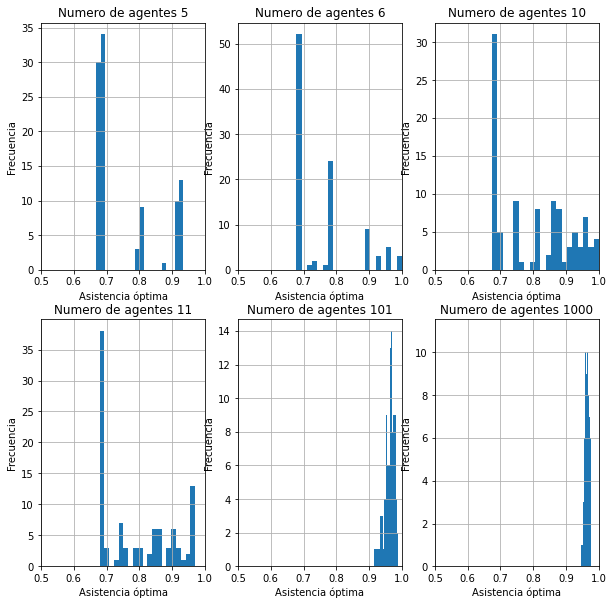

In [62]:
fig = plt.figure(figsize=(10,10))
contador = 1
for n,grp in df.groupby('Numero_agentes'):
    ax = fig.add_subplot(2,3,contador)
    grp['Asistencia_optima'].hist(bins = 20)
    ax.set_title('Numero de agentes '+str(n))
    contador += 1
    ax.set_xlim([0.5,1])
    ax.set_xlabel('Asistencia óptima')
    ax.set_ylabel('Frecuencia')

Text(0, 0.5, 'Promedio asistencia óptima\nsobre 100 simulaciones')

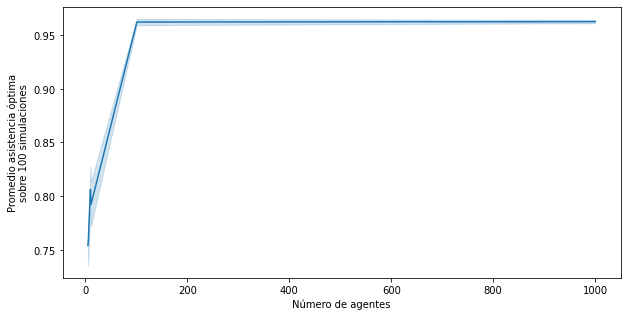

In [39]:
fig = plt.subplots(figsize=(10,5))
sns.lineplot(x=df['Numero_agentes'], y=df['Asistencia_optima'])
plt.xlabel('Número de agentes')
plt.ylabel('Promedio asistencia óptima\nsobre 100 simulaciones')

Medida de recompensa total:

$$\frac{\sum_{a, r} recompensa(a, r)}{A*R}$$

In [50]:
data_recomp = data.groupby(['Numero_agentes', 'Identificador'])["Puntaje"].sum().reset_index()
data_recomp["Puntaje promedio"]=data_recomp["Puntaje"]/(num_rondas*data_recomp["Numero_agentes"])
data_recomp['Puntaje promedio'].describe()


count    600.000000
mean      -0.022852
std        0.048038
min       -0.109890
25%       -0.073352
50%       -0.006593
75%        0.007861
max        0.054945
Name: Puntaje promedio, dtype: float64

Text(0, 0.5, 'Promedio puntaje \nsobre 100 simulaciones')

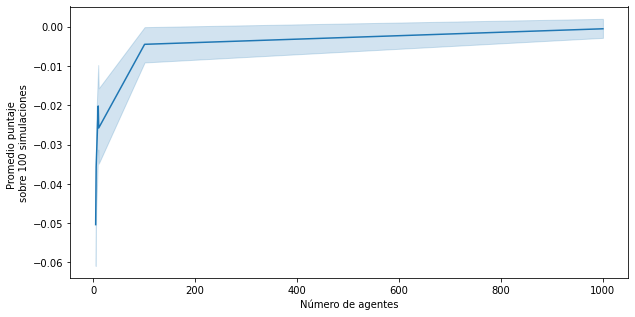

In [51]:
fig = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_recomp['Numero_agentes'], y=data_recomp['Puntaje promedio'])
plt.xlabel('Número de agentes')
plt.ylabel('Promedio puntaje \nsobre 100 simulaciones')

Medida de equidad en al distribución de recursos:

Índice de Gini:
$X_{j}$ : Puntaje acumulado del agente $j$  
$$N+1-2\frac{\sum_{i=1}^N\sum_{j=1}^i X_{j}}{\sum_{k=1}^N X_{k}}$$

In [42]:
def gini(x):
        # The rest of the code requires numpy arrays.
        x = np.asarray(x) #convierte x en un vector
        sorted_x = np.sort(x) #los organiza de menor a mayor
        n = len(x) #tamaño del vector x
        cumx = np.cumsum(sorted_x, dtype=float)# va haciendo la suma acumulativa
        gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n #esta es una formula muy rara, esta en alternate expression de Wikipedia
        pe_line = np.linspace(start=0.0, stop=1.0, num=len(cumx))
        area_under_lorenz = np.trapz(y=cumx, dx=1/len(cumx)) #area de la suma acumulada, zona azul
        area_under_pe = np.trapz(y=pe_line, dx=1/len(cumx)) #area de la linea perfecta, caso perfecto
        cumx=cumx/cumx[-1] #normalizando para que se vea en la grafica bien
        # The above formula, with all weights equal to 1 simplifies to:
        return gini, pe_line,area_under_lorenz,area_under_pe,cumx

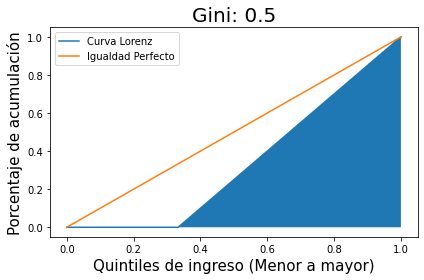

In [43]:
gini, pe_line,area_under_lorenz,area_under_pe,cumx = gini([1,1,0,0])
from matplotlib import pyplot as plt

plt.plot(pe_line, cumx, label='Curva Lorenz')
plt.plot(pe_line, pe_line, label='Igualdad Perfecto')
plt.fill_between(pe_line, cumx)
plt.title('Gini: {}'.format(gini), fontsize=20)
plt.ylabel('Porcentaje de acumulación', fontsize=15)
plt.xlabel('Quintiles de ingreso (Menor a mayor)', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
def gini1(x):
    x = np.asarray(x) 
    sorted_x = np.sort(x) 
    n = len(x) 
    cumx = np.cumsum(sorted_x, dtype=float)
    try:
        gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    except:
        gini = 0
    return np.round(gini,3)

In [66]:
data_aux = data.copy()
data_aux['Puntaje normalizado'] = data_aux['Puntaje'] + 1
data_aux = data_aux.groupby(['Numero_agentes', 'Identificador', 'Agente'])['Puntaje normalizado'].sum().reset_index()
data_aux.head()

,Numero_agentes,Identificador,Agente,Puntaje normalizado
0,5,1200,0,11
1,5,1200,1,1
2,5,1200,2,1
3,5,1200,3,1
4,5,1200,4,10


In [67]:
data_aux['Gini'] = data_aux.groupby(['Numero_agentes','Identificador'])['Puntaje normalizado'].transform(func = gini1)
data_aux

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


,Numero_agentes,Identificador,Agente,Puntaje normalizado,Gini
0,5,1200,0,11,0.483
1,5,1200,1,1,0.483
2,5,1200,2,1,0.483
3,5,1200,3,1,0.483
4,5,1200,4,10,0.483
...,...,...,...,...,...
113295,1000,1799,995,9,0.065
113296,1000,1799,996,10,0.065
113297,1000,1799,997,10,0.065
113298,1000,1799,998,11,0.065


In [68]:
data_gini = data_aux.groupby(['Numero_agentes', 'Identificador']).agg({'Gini':'first'}).reset_index()
data_gini.shape

(600, 3)

In [69]:
data_gini['Gini'].isna().value_counts()

False    598
True       2
Name: Gini, dtype: int64

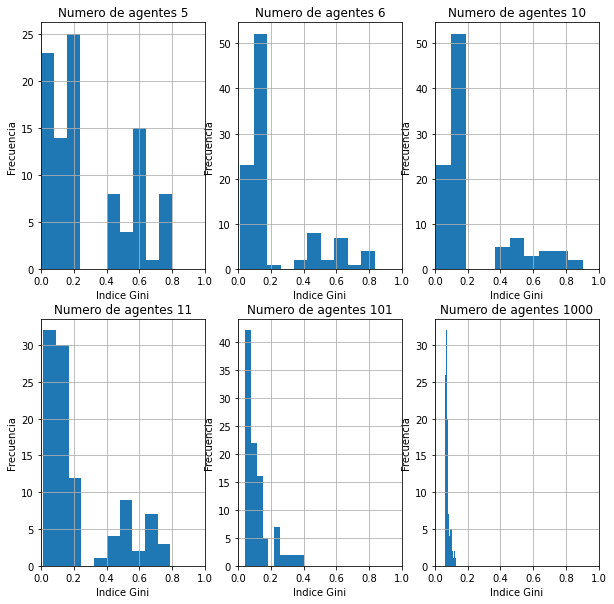

In [71]:
fig = plt.figure(figsize=(10,10))
contador = 1
for n,grp in data_gini.groupby('Numero_agentes'):
    ax = fig.add_subplot(2,3,contador)
    grp['Gini'].hist(bins = 10)
    ax.set_title('Numero de agentes '+str(n))
    contador += 1
    ax.set_xlim([0,1])
    ax.set_xlabel('Indice Gini')
    ax.set_ylabel('Frecuencia')

Links:

* https://stackoverflow.com/questions/31416664/python-gini-coefficient-calculation-using-numpy?noredirect=1&lq=1
* https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python?noredirect=1&lq=1